In [1]:
import pandas as pd
import numpy as np
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score


C:\Users\toubia\anaconda3\envs\notebook\Lib\site-packages\tslearn\bases\bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


In [81]:
df_heat = pd.read_csv('heating_consumption.csv')  
date_range = pd.date_range(start='2021-01-01', end='2022-12-28', freq='D')

df_heat['date'] = date_range

In [82]:
df_heating = df_heat[df_heat.iloc[:, -25:-1].sum(axis=1) != 0]      


In [83]:
df_heating


,0.0000,0.0000.1,0.0000.2,0.0000.3,0.0000.4,0.0000.5,0.0000.6,0.0000.7,0.0000.8,0.0000.9,...,0.0000.15,0.0000.16,0.0000.17,0.0000.18,0.0000.19,0.0000.20,0.0000.21,0.0000.22,0.0000.23,date
2,0.0,0.0,0.0,0.0,0.0,0.598,0.926,2.525,1.891,0.560,...,0.109,0.318,0.001,0.0,0.0,0.0,0.0,0.0,0.0,2021-01-03
3,0.0,0.0,0.0,0.0,0.0,0.189,0.694,2.227,1.544,0.605,...,0.823,0.808,0.264,0.0,0.0,0.0,0.0,0.0,0.0,2021-01-04
4,0.0,0.0,0.0,0.0,0.0,0.152,1.793,1.702,1.333,1.548,...,0.120,0.328,0.070,0.0,0.0,0.0,0.0,0.0,0.0,2021-01-05
5,0.0,0.0,0.0,0.0,0.0,0.663,2.878,2.513,1.871,1.842,...,0.637,0.732,0.063,0.0,0.0,0.0,0.0,0.0,0.0,2021-01-06
6,0.0,0.0,0.0,0.0,0.0,0.669,2.677,2.805,1.742,0.348,...,0.286,0.269,0.330,0.0,0.0,0.0,0.0,0.0,0.0,2021-01-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
716,0.0,0.0,0.0,0.0,0.0,0.012,0.828,0.017,0.032,0.017,...,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,2022-12-18
717,0.0,0.0,0.0,0.0,0.0,0.024,0.058,0.016,0.016,0.000,...,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,2022-12-19
718,0.0,0.0,0.0,0.0,0.0,0.028,0.038,0.017,0.000,0.016,...,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,2022-12-20
719,0.0,0.0,0.0,0.0,0.0,0.021,0.040,0.016,0.032,0.000,...,0.000,0.007,0.007,0.0,0.0,0.0,0.0,0.0,0.0,2022-12-21


In [27]:

def apply_kmeans(data, n_clusters=3):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    df_heating_with_cluster=data.copy()
    df_heating_with_cluster['cluster'] = kmeans.fit_predict(data)
    return kmeans, df_heating_with_cluster


In [57]:
def plot_clusters_single_variable(data_normalized, cluster_assignments, kmeans=None, column_index=0, y_label="Valeur", num_labels=10):
    cluster_centers = kmeans.cluster_centers_

    fig, axes = plt.subplots(2, 2, figsize=(14, 12))

    all_values = []
    for cluster_id, cluster_center in enumerate(cluster_centers):
        cluster_data = data_normalized[cluster_assignments == cluster_id].iloc[:, column_index:-1]
        all_values.extend(cluster_data.values.flatten())  
    y_min = np.min(all_values)
    y_max = np.max(all_values)

    for cluster_id, cluster_center in enumerate(cluster_centers):
        cluster_data = data_normalized[cluster_assignments == cluster_id].iloc[:, column_index:-1]
        
        num_series = len(cluster_data)
        
        for idx, row in cluster_data.iterrows():
            axes[cluster_id // 2, cluster_id % 2].plot(range(24), row, color='gray', alpha=0.5)

        axes[cluster_id // 2, cluster_id % 2].plot(range(24), cluster_center, color='red', linewidth=3, 
                                                     label=f"{num_series} séries")

        axes[cluster_id // 2, cluster_id % 2].set_title(f"Séries temporelles du Cluster {cluster_id}")
        axes[cluster_id // 2, cluster_id % 2].set_xlabel("Heures")
        axes[cluster_id // 2, cluster_id % 2].set_ylabel(y_label)
        
        axes[cluster_id // 2, cluster_id % 2].set_ylim([y_min, y_max])
        axes[cluster_id // 2, cluster_id % 2].grid(True)

        axes[cluster_id // 2, cluster_id % 2].legend(loc='upper right', bbox_to_anchor=(1.1, 1))

    plt.tight_layout()
    plt.show()


In [63]:
def plot_cluster_centers(kmeans, y_label="Valeur"):
    cluster_centers = kmeans.cluster_centers_

    num_clusters = len(cluster_centers)
    colors = plt.cm.get_cmap('tab10', num_clusters) 
    plt.figure(figsize=(10, 6))

    for cluster_id, cluster_center in enumerate(cluster_centers):
        plt.plot(range(24), cluster_center, color=colors(cluster_id), linewidth=3, label=f"Centre du cluster {cluster_id}")

    plt.title("Centres des Clusters")
    plt.xlabel("Heures")
    plt.ylabel(y_label)
    plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1))
    plt.grid(True)
    plt.tight_layout()

    plt.show()

In [85]:
df_heating2=df_heating.drop(columns=["date"])
kmeans, df_heating_with_cluster = apply_kmeans(df_heating2, 4)
df_heating_with_cluster["date"]=df_heating["date"]
df_heating_with_cluster.to_csv("df_heating_conso_with_cluster.csv", index=False)


In [86]:
df_heating_with_cluster

,0.0000,0.0000.1,0.0000.2,0.0000.3,0.0000.4,0.0000.5,0.0000.6,0.0000.7,0.0000.8,0.0000.9,...,0.0000.16,0.0000.17,0.0000.18,0.0000.19,0.0000.20,0.0000.21,0.0000.22,0.0000.23,cluster,date
2,0.0,0.0,0.0,0.0,0.0,0.598,0.926,2.525,1.891,0.560,...,0.318,0.001,0.0,0.0,0.0,0.0,0.0,0.0,2,2021-01-03
3,0.0,0.0,0.0,0.0,0.0,0.189,0.694,2.227,1.544,0.605,...,0.808,0.264,0.0,0.0,0.0,0.0,0.0,0.0,1,2021-01-04
4,0.0,0.0,0.0,0.0,0.0,0.152,1.793,1.702,1.333,1.548,...,0.328,0.070,0.0,0.0,0.0,0.0,0.0,0.0,1,2021-01-05
5,0.0,0.0,0.0,0.0,0.0,0.663,2.878,2.513,1.871,1.842,...,0.732,0.063,0.0,0.0,0.0,0.0,0.0,0.0,1,2021-01-06
6,0.0,0.0,0.0,0.0,0.0,0.669,2.677,2.805,1.742,0.348,...,0.269,0.330,0.0,0.0,0.0,0.0,0.0,0.0,2,2021-01-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
716,0.0,0.0,0.0,0.0,0.0,0.012,0.828,0.017,0.032,0.017,...,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0,2022-12-18
717,0.0,0.0,0.0,0.0,0.0,0.024,0.058,0.016,0.016,0.000,...,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0,2022-12-19
718,0.0,0.0,0.0,0.0,0.0,0.028,0.038,0.017,0.000,0.016,...,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0,2022-12-20
719,0.0,0.0,0.0,0.0,0.0,0.021,0.040,0.016,0.032,0.000,...,0.007,0.007,0.0,0.0,0.0,0.0,0.0,0.0,0,2022-12-21


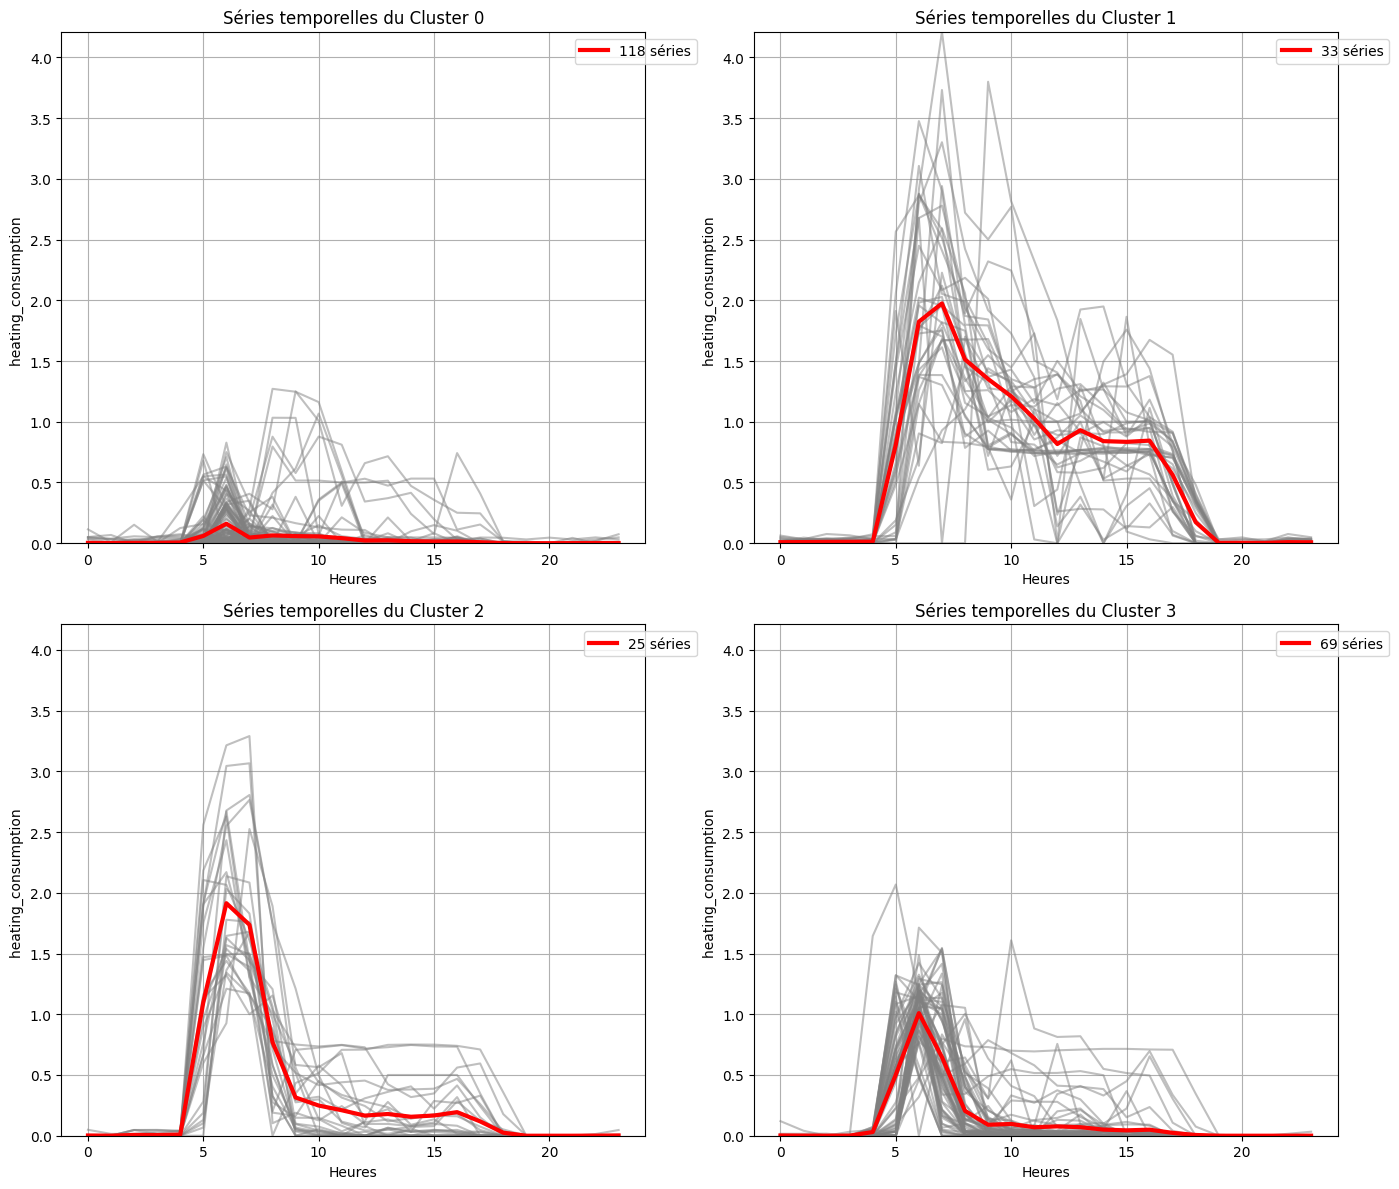

In [65]:
plot_clusters_single_variable(df_heating_with_cluster, df_heating_with_cluster["cluster"],kmeans=kmeans, column_index=0, y_label="heating_consumption ")


C:\Users\toubia\AppData\Local\Temp\ipykernel_14520\2220736720.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', num_clusters)  # Utilise la palette tab10 pour les couleurs distinctes


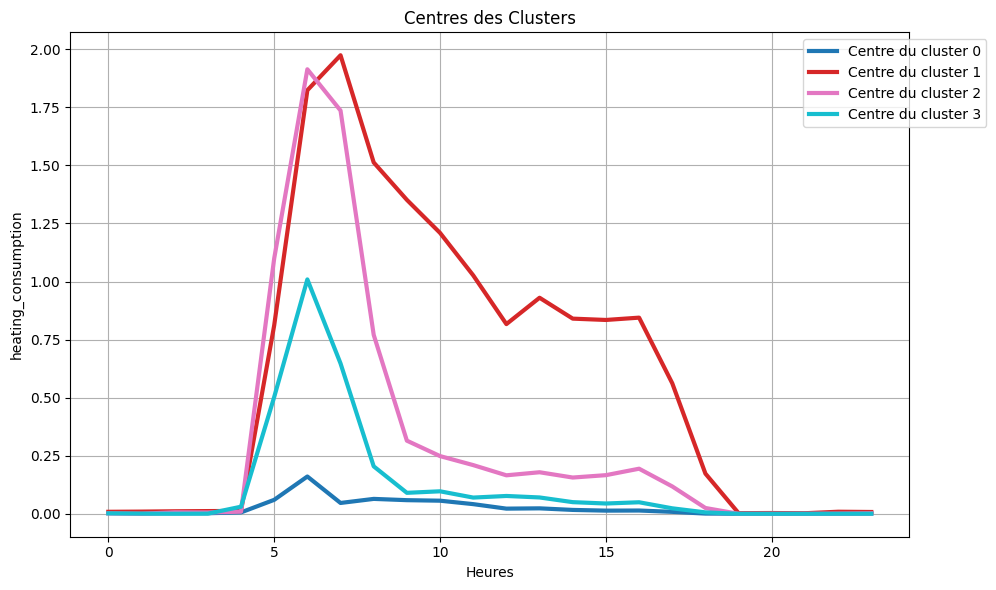

In [66]:
plot_cluster_centers(kmeans, y_label="heating_consumption")


In [92]:
df_temp_out = pd.read_csv('outdoor_temperature.csv')  
df_temp_in = pd.read_csv('indoor_temperature.csv')  
df_heat = pd.read_csv('df_heating_conso_with_cluster.csv')  
date_range = pd.date_range(start='2021-01-01', end='2022-12-28', freq='D')

df_temp_out.insert(0, 'date', date_range)
df_temp_in.insert(0, 'date', date_range)

df_heat['date'] = pd.to_datetime(df_heat['date'], errors='coerce')

df_temp_out['date'] = pd.to_datetime(df_temp_out['date'])
df_temp_in['date'] = pd.to_datetime(df_temp_in['date'])

df_combined = df_heat.merge(df_temp_out, on='date', how='inner').merge(df_temp_in, on='date', how='inner')


print(df_combined.columns)

Index(['0.0000', '0.0000.1', '0.0000.2', '0.0000.3', '0.0000.4', '0.0000.5',
       '0.0000.6', '0.0000.7', '0.0000.8', '0.0000.9', '0.0000.10',
       '0.0000.11', '0.0000.12', '0.0000.13', '0.0000.14', '0.0000.15',
       '0.0000.16', '0.0000.17', '0.0000.18', '0.0000.19', '0.0000.20',
       '0.0000.21', '0.0000.22', '0.0000.23', 'cluster', 'date', '5.2000',
       '4.2000', '4.4000', '3.3000', '1.7000', '2.8000', '1.9000', '1.9000.1',
       '2.0000', '2.3000', '2.3000.1', '2.5000', '3.1000', '2.6000',
       '3.1000.1', '3.1000.2', '2.6000.1', '2.0000.1', '1.2000', '0.6000',
       '0.1000', '0.7000', '1.1000', '0.9000', '19.9727', '19.9000', '19.8455',
       '19.6091', '19.2182', '19.1182', '19.1909', '18.9182', '18.7727',
       '18.6455', '18.7364', '18.8818', '19.0091', '19.0545', '19.1636',
       '19.2727', '19.2364', '19.4818', '19.3545', '18.9909', '18.9909.1',
       '18.9091', '18.6727', '18.6364'],
      dtype='object')


In [93]:
print(df_combined['date'][df_combined['cluster']==0.0])

18    2021-01-27
19    2021-01-28
21    2021-02-02
22    2021-02-03
23    2021-02-04
         ...    
240   2022-12-18
241   2022-12-19
242   2022-12-20
243   2022-12-21
244   2022-12-22
Name: date, Length: 118, dtype: datetime64[ns]


In [115]:
def plot_average_temperature_per_cluster(df_combined, external_temp_columns,text):
    num_clusters = len(df_combined['cluster'].unique())

    nrows = (num_clusters + 1) // 2 
    ncols = 2  
    all_outdoor_temps = []
    for cluster in df_combined['cluster'].unique():
        cluster_data = df_combined[df_combined['cluster'] == cluster]
        avg_outdoor_temp = cluster_data[external_temp_columns].mean(axis=1)
        all_outdoor_temps.extend(avg_outdoor_temp)

    y_min = min(all_outdoor_temps)
    y_max = max(all_outdoor_temps)

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14, 8))

    axes = axes.flatten()

    for cluster_id, cluster in enumerate(df_combined['cluster'].unique()):
        cluster_data = df_combined[df_combined['cluster'] == cluster]
        

        avg_outdoor_temp = cluster_data[external_temp_columns].mean(axis=1)
        
        axes[cluster_id].plot(cluster_data['date'], avg_outdoor_temp, label=f'Cluster {cluster}', linestyle='-', marker='o')
        
        axes[cluster_id].set_title(f"{text} - Cluster {cluster}")
        axes[cluster_id].set_xlabel("Jour")
        axes[cluster_id].set_ylabel(text)
        axes[cluster_id].set_ylim(y_min, y_max)  
        axes[cluster_id].grid(True)
        axes[cluster_id].legend()

    if num_clusters % 2 != 0:
        axes[-1].axis('off')

    plt.tight_layout()
    plt.show()
    


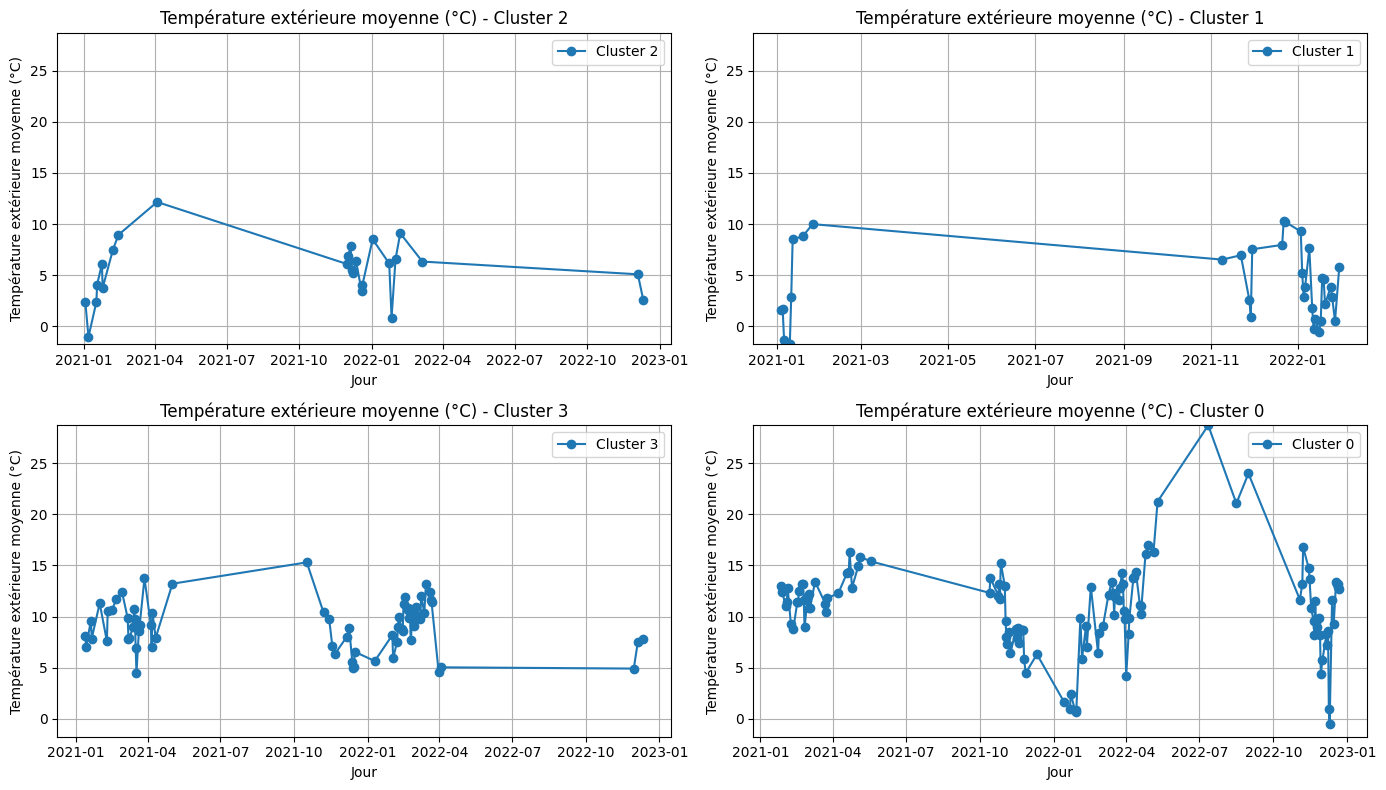

In [116]:
columns_temp_out = df_temp_out.drop(columns=["date"]).columns  


plot_average_temperature_per_cluster(df_combined, columns_temp_out,"Température extérieure moyenne (°C)")


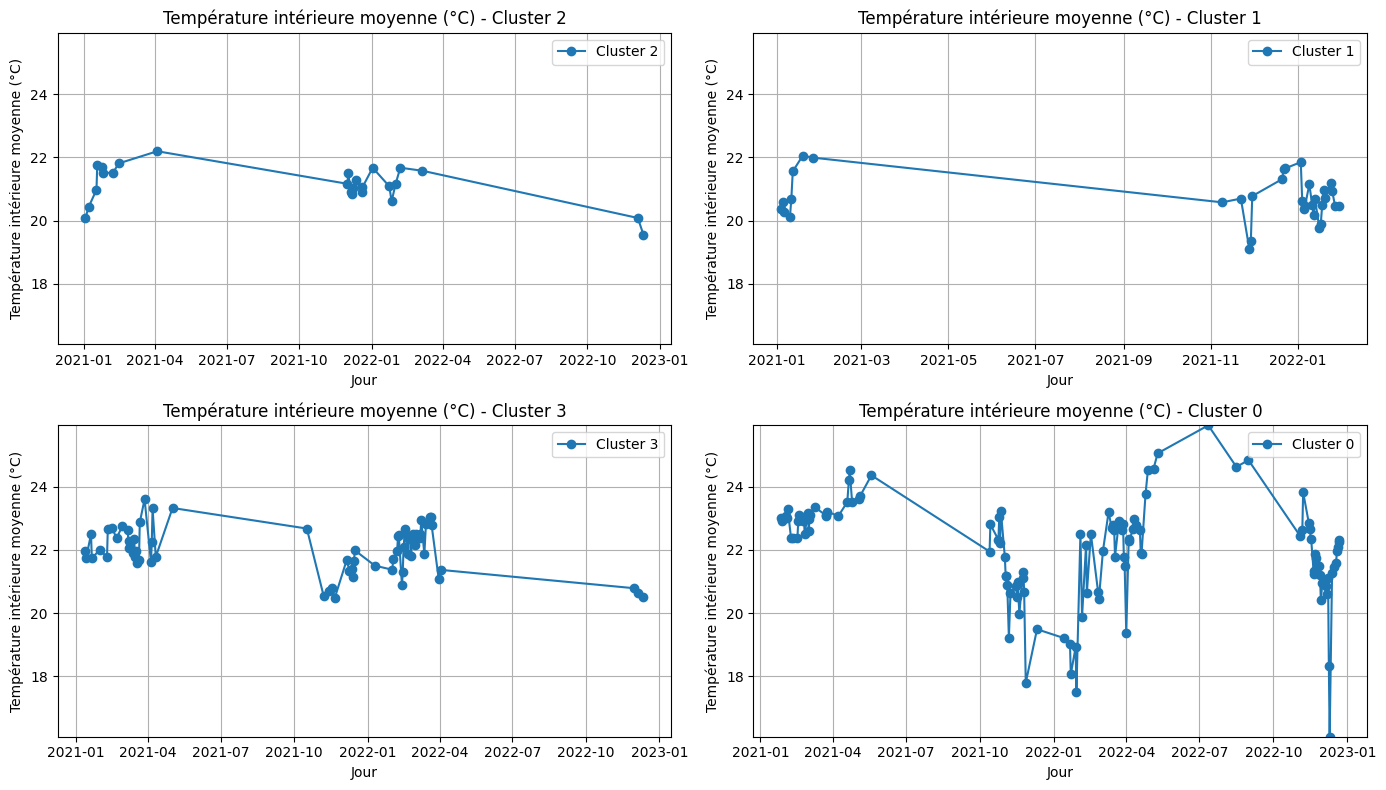

In [117]:
columns_temp_in = df_temp_in.drop(columns=["date"]).columns  

plot_average_temperature_per_cluster(df_combined, columns_temp_in,"Température intérieure moyenne (°C)")


In [118]:

labels = df_heating_with_cluster['cluster'] 

df_heating_with_cluster2=df_heating_with_cluster.drop(columns=["date"])
sil_score = silhouette_score(df_heating_with_cluster2, labels, metric='euclidean')
db_score = davies_bouldin_score(df_heating_with_cluster2, labels)

print(f"Davies-Bouldin Index: {db_score}")
print(f"Silhouette Score: {sil_score}")

Davies-Bouldin Index: 1.0085353852424699
Silhouette Score: 0.608919025759574


In [126]:
heating_dict = {}
columns_temp_out = df_temp_out.drop(columns=["date"]).columns  
columns_temp_in = df_temp_in.drop(columns=["date"]).columns  
columns_heat=df_heat.drop(columns=["date","cluster"]).columns  

for idx, row in df_combined.iterrows():
    heating_dict[idx] = {
        'date': row['date'],
        'text': row.loc[columns_temp_out].values.tolist(),
        'tint': row.loc[columns_temp_in].values.tolist(),
        'heating': row.loc[columns_heat].values.tolist(),
        'label': row['cluster'] 
    }


In [128]:
df= pd.DataFrame.from_dict(heating_dict, orient='index')
df.to_csv("df_final.csv", index=False)
